In [40]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [41]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [42]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [43]:
# '탄산음료'만 빼서 df생성
item = '탄산음료'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

# MAD기법 적용할꺼면.....

In [44]:
# MAD적용
gs_day_w['outlier'] = pd.DataFrame(mad_based_outlier(gs_day_w['qty']))
gs_day_w = gs_day_w.loc[gs_day_w.outlier==False]

# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

In [45]:
list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
lowVIF(w,40,list_col)

,VIF_Factor,features
0,3.715302,temp
1,4.682044,PM10
2,6.314379,cloud
3,7.886587,lgt_time
4,8.692697,wind


In [46]:
train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만, 
# 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
# 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not',
# 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
combined = gs_day_w.loc[:,list_col+['rain_or_not','snow_or_not']]
target = gs_day_w.loc[:,'qty']

In [10]:
combined.head(2)

,temp,cloud,wind,lgt_time,PM10,rain_or_not,snow_or_not
0,1.2,7.0,1.6,2.1,68.696500,비x,눈x
1,5.7,7.8,2.0,3.6,53.618667,비x,눈x


In [11]:
Xy = pd.concat([target,combined], axis=1)

In [12]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [13]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 5
오브젝트형 자료 컬럼 갯수 : 2


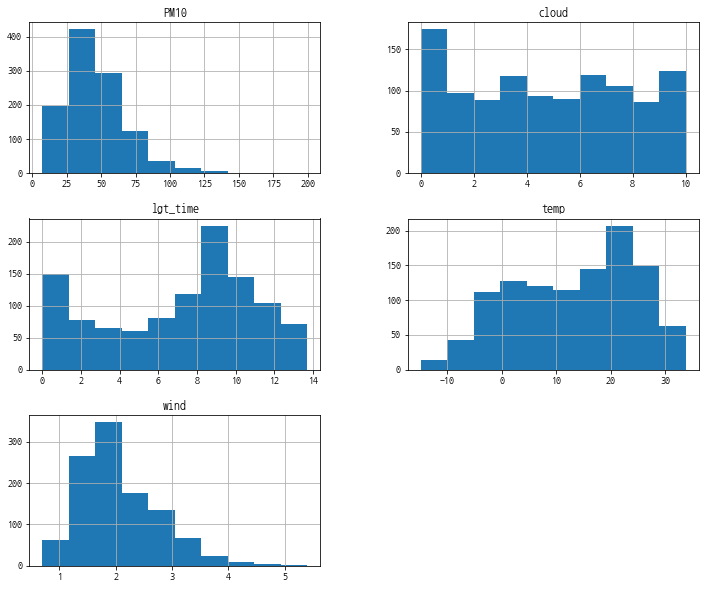

In [14]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

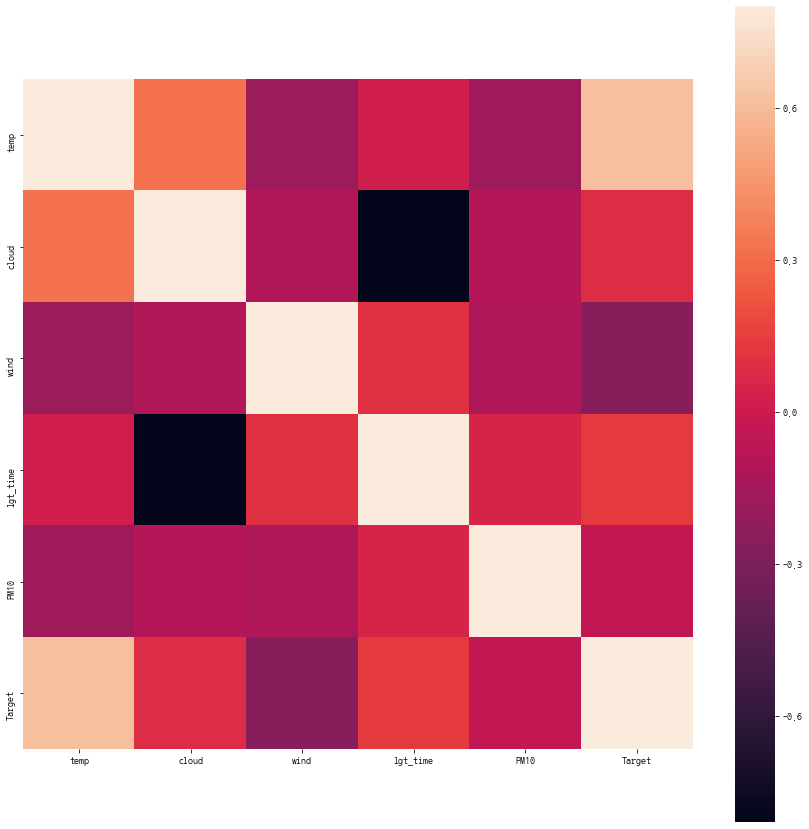

In [15]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [47]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))


분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 9 개의 columns이 있었습니다.


In [38]:
combined.columns = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o','snow_or_not_o']
Xy = pd.concat([target,combined], axis=1)

In [20]:
# (combined.shape[0] * 2)//3 첫 2/3 : 730
# 하루정도 차이 있겠지만, 2년/1년
cut_line = (combined.shape[0] * 2)//3
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(730, 7)

In [23]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0719 14:15:37.054354   468 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 14:15:37.070312   468 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 14:15:37.072306   468 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0719 14:15:37.131149   468 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = 'GS-mad적용'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5' 

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

checkpoint_name

'GS-mad적용탄산음료date-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

# xxxyyzzz.hdf5 자료가 주워 졌음 ↓ 요건 실행 안해도 된다.

In [25]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0719 14:15:40.816736   468 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0719 14:15:40.927439   468 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 584 samples, validate on 146 samples
Epoch 1/500
584/584 [==============================] - 0s 540us/step - loss: 5931.2157 - mean_absolute_error: 5931.2157 - val_loss: 5767.0187 - val_mean_absolute_error: 5767.0187

Epoch 00001: val_loss improved from inf to 5767.01868, saving model to GS-mad적용탄산음료date-Weights-001--5767.01868-cat02-vf05.hdf5
Epoch 2/500
584/584 [==============================] - 0s 82us/step - loss: 4621.9034 - mean_absolute_error: 4621.9034 - val_loss: 2111.0852 - val_mean_absolute_error: 2111.0852

Epoch 00002: val_loss improved from 5767.01868 to 2111.08522, saving model to GS-mad적용탄산음료date-Weights-002--2111.08522-cat02-vf05.hdf5
Epoch 3/500
584/584 [==============================] - 0s 79us/step - loss: 1716.6970 - mean_absolute_error: 1716.6970 - val_loss: 1841.7100 - val_mean_absolute_error: 1841.7100

Epoch 00003: val_loss improved from 2111.08522 to 1841.71001, saving model to GS-mad적용탄산음료date-Weights-003--1841.71001-cat02-vf05.hdf5
Epoch 4/500
584/58

584/584 [==============================] - 0s 67us/step - loss: 1088.6188 - mean_absolute_error: 1088.6188 - val_loss: 1213.0239 - val_mean_absolute_error: 1213.0239

Epoch 00032: val_loss did not improve from 1091.32137
Epoch 33/500
584/584 [==============================] - 0s 68us/step - loss: 1097.8181 - mean_absolute_error: 1097.8181 - val_loss: 1112.7087 - val_mean_absolute_error: 1112.7087

Epoch 00033: val_loss did not improve from 1091.32137
Epoch 34/500
584/584 [==============================] - 0s 75us/step - loss: 1091.0212 - mean_absolute_error: 1091.0212 - val_loss: 1144.7618 - val_mean_absolute_error: 1144.7618

Epoch 00034: val_loss did not improve from 1091.32137
Epoch 35/500
584/584 [==============================] - 0s 72us/step - loss: 1103.5261 - mean_absolute_error: 1103.5261 - val_loss: 1365.1987 - val_mean_absolute_error: 1365.1987

Epoch 00035: val_loss did not improve from 1091.32137
Epoch 36/500
584/584 [==============================] - 0s 85us/step - loss: 

584/584 [==============================] - 0s 82us/step - loss: 1074.6990 - mean_absolute_error: 1074.6990 - val_loss: 1079.5914 - val_mean_absolute_error: 1079.5914

Epoch 00065: val_loss did not improve from 981.79425
Epoch 66/500
584/584 [==============================] - 0s 120us/step - loss: 1046.1907 - mean_absolute_error: 1046.1907 - val_loss: 1202.8717 - val_mean_absolute_error: 1202.8717

Epoch 00066: val_loss did not improve from 981.79425
Epoch 67/500
584/584 [==============================] - 0s 91us/step - loss: 1074.2513 - mean_absolute_error: 1074.2513 - val_loss: 1072.3858 - val_mean_absolute_error: 1072.3858

Epoch 00067: val_loss did not improve from 981.79425
Epoch 68/500
584/584 [==============================] - 0s 81us/step - loss: 1053.9183 - mean_absolute_error: 1053.9183 - val_loss: 1039.4680 - val_mean_absolute_error: 1039.4680

Epoch 00068: val_loss did not improve from 981.79425
Epoch 69/500
584/584 [==============================] - 0s 84us/step - loss: 104

Epoch 99/500
584/584 [==============================] - 0s 72us/step - loss: 1072.2144 - mean_absolute_error: 1072.2144 - val_loss: 857.3825 - val_mean_absolute_error: 857.3825

Epoch 00099: val_loss improved from 912.46453 to 857.38246, saving model to GS-mad적용탄산음료date-Weights-099--857.38246-cat02-vf05.hdf5
Epoch 100/500
584/584 [==============================] - 0s 73us/step - loss: 1104.9273 - mean_absolute_error: 1104.9273 - val_loss: 1228.8110 - val_mean_absolute_error: 1228.8110

Epoch 00100: val_loss did not improve from 857.38246
Epoch 101/500
584/584 [==============================] - 0s 72us/step - loss: 1119.9484 - mean_absolute_error: 1119.9484 - val_loss: 1104.0869 - val_mean_absolute_error: 1104.0869

Epoch 00101: val_loss did not improve from 857.38246
Epoch 102/500
584/584 [==============================] - 0s 76us/step - loss: 1034.6408 - mean_absolute_error: 1034.6408 - val_loss: 936.5135 - val_mean_absolute_error: 936.5135

Epoch 00102: val_loss did not improve from 


Epoch 00133: val_loss did not improve from 856.02253
Epoch 134/500
584/584 [==============================] - 0s 106us/step - loss: 1012.5966 - mean_absolute_error: 1012.5966 - val_loss: 1022.0754 - val_mean_absolute_error: 1022.0754

Epoch 00134: val_loss did not improve from 856.02253
Epoch 135/500
584/584 [==============================] - 0s 75us/step - loss: 1013.0317 - mean_absolute_error: 1013.0317 - val_loss: 905.5300 - val_mean_absolute_error: 905.5300

Epoch 00135: val_loss did not improve from 856.02253
Epoch 136/500
584/584 [==============================] - 0s 91us/step - loss: 1004.3411 - mean_absolute_error: 1004.3411 - val_loss: 997.4339 - val_mean_absolute_error: 997.4339

Epoch 00136: val_loss did not improve from 856.02253
Epoch 137/500
584/584 [==============================] - 0s 75us/step - loss: 1013.8736 - mean_absolute_error: 1013.8736 - val_loss: 1113.0934 - val_mean_absolute_error: 1113.0934

Epoch 00137: val_loss did not improve from 856.02253
Epoch 138/500

584/584 [==============================] - 0s 89us/step - loss: 1002.4064 - mean_absolute_error: 1002.4064 - val_loss: 876.1442 - val_mean_absolute_error: 876.1442

Epoch 00168: val_loss did not improve from 800.27454
Epoch 169/500
584/584 [==============================] - 0s 113us/step - loss: 988.1369 - mean_absolute_error: 988.1369 - val_loss: 843.7889 - val_mean_absolute_error: 843.7889

Epoch 00169: val_loss did not improve from 800.27454
Epoch 170/500
584/584 [==============================] - 0s 91us/step - loss: 979.3173 - mean_absolute_error: 979.3173 - val_loss: 840.0514 - val_mean_absolute_error: 840.0514

Epoch 00170: val_loss did not improve from 800.27454
Epoch 171/500
584/584 [==============================] - 0s 102us/step - loss: 988.8182 - mean_absolute_error: 988.8182 - val_loss: 1103.8429 - val_mean_absolute_error: 1103.8429

Epoch 00171: val_loss did not improve from 800.27454
Epoch 172/500
584/584 [==============================] - 0s 92us/step - loss: 1015.1308 

584/584 [==============================] - 0s 99us/step - loss: 977.0019 - mean_absolute_error: 977.0019 - val_loss: 902.3734 - val_mean_absolute_error: 902.3734

Epoch 00203: val_loss did not improve from 769.45893
Epoch 204/500
584/584 [==============================] - 0s 133us/step - loss: 965.7987 - mean_absolute_error: 965.7987 - val_loss: 897.7884 - val_mean_absolute_error: 897.7884

Epoch 00204: val_loss did not improve from 769.45893
Epoch 205/500
584/584 [==============================] - 0s 102us/step - loss: 974.5006 - mean_absolute_error: 974.5006 - val_loss: 801.5605 - val_mean_absolute_error: 801.5605

Epoch 00205: val_loss did not improve from 769.45893
Epoch 206/500
584/584 [==============================] - 0s 108us/step - loss: 1001.1391 - mean_absolute_error: 1001.1391 - val_loss: 796.2651 - val_mean_absolute_error: 796.2651

Epoch 00206: val_loss did not improve from 769.45893
Epoch 207/500
584/584 [==============================] - 0s 97us/step - loss: 1003.4275 -

584/584 [==============================] - 0s 108us/step - loss: 981.7244 - mean_absolute_error: 981.7244 - val_loss: 817.3395 - val_mean_absolute_error: 817.3395

Epoch 00238: val_loss did not improve from 738.46532
Epoch 239/500
584/584 [==============================] - 0s 102us/step - loss: 952.4139 - mean_absolute_error: 952.4139 - val_loss: 936.9504 - val_mean_absolute_error: 936.9504

Epoch 00239: val_loss did not improve from 738.46532
Epoch 240/500
584/584 [==============================] - 0s 102us/step - loss: 970.9661 - mean_absolute_error: 970.9661 - val_loss: 857.4925 - val_mean_absolute_error: 857.4925

Epoch 00240: val_loss did not improve from 738.46532
Epoch 241/500
584/584 [==============================] - 0s 97us/step - loss: 949.4440 - mean_absolute_error: 949.4440 - val_loss: 853.0148 - val_mean_absolute_error: 853.0148

Epoch 00241: val_loss did not improve from 738.46532
Epoch 242/500
584/584 [==============================] - 0s 123us/step - loss: 955.8348 - m

584/584 [==============================] - 0s 113us/step - loss: 947.8820 - mean_absolute_error: 947.8820 - val_loss: 813.1626 - val_mean_absolute_error: 813.1626

Epoch 00272: val_loss did not improve from 711.33196
Epoch 273/500
584/584 [==============================] - 0s 108us/step - loss: 1002.9250 - mean_absolute_error: 1002.9250 - val_loss: 841.7433 - val_mean_absolute_error: 841.7433

Epoch 00273: val_loss did not improve from 711.33196
Epoch 274/500
584/584 [==============================] - 0s 99us/step - loss: 941.8773 - mean_absolute_error: 941.8773 - val_loss: 778.8721 - val_mean_absolute_error: 778.8721

Epoch 00274: val_loss did not improve from 711.33196
Epoch 275/500
584/584 [==============================] - 0s 130us/step - loss: 952.6484 - mean_absolute_error: 952.6484 - val_loss: 789.6262 - val_mean_absolute_error: 789.6262

Epoch 00275: val_loss did not improve from 711.33196
Epoch 276/500
584/584 [==============================] - 0s 109us/step - loss: 931.7955 -


Epoch 00307: val_loss did not improve from 711.33196
Epoch 308/500
584/584 [==============================] - 0s 121us/step - loss: 935.3286 - mean_absolute_error: 935.3286 - val_loss: 692.3551 - val_mean_absolute_error: 692.3551

Epoch 00308: val_loss improved from 711.33196 to 692.35514, saving model to GS-mad적용탄산음료date-Weights-308--692.35514-cat02-vf05.hdf5
Epoch 309/500
584/584 [==============================] - 0s 130us/step - loss: 939.7901 - mean_absolute_error: 939.7901 - val_loss: 821.3884 - val_mean_absolute_error: 821.3884

Epoch 00309: val_loss did not improve from 692.35514
Epoch 310/500
584/584 [==============================] - 0s 116us/step - loss: 923.5802 - mean_absolute_error: 923.5802 - val_loss: 768.6669 - val_mean_absolute_error: 768.6669

Epoch 00310: val_loss did not improve from 692.35514
Epoch 311/500
584/584 [==============================] - 0s 132us/step - loss: 927.7115 - mean_absolute_error: 927.7115 - val_loss: 843.5314 - val_mean_absolute_error: 843.53

584/584 [==============================] - 0s 125us/step - loss: 909.4242 - mean_absolute_error: 909.4242 - val_loss: 768.3101 - val_mean_absolute_error: 768.3101

Epoch 00343: val_loss did not improve from 692.35514
Epoch 344/500
584/584 [==============================] - 0s 121us/step - loss: 912.9553 - mean_absolute_error: 912.9553 - val_loss: 771.1003 - val_mean_absolute_error: 771.1003

Epoch 00344: val_loss did not improve from 692.35514
Epoch 345/500
584/584 [==============================] - 0s 135us/step - loss: 946.5345 - mean_absolute_error: 946.5345 - val_loss: 753.9817 - val_mean_absolute_error: 753.9817

Epoch 00345: val_loss did not improve from 692.35514
Epoch 346/500
584/584 [==============================] - 0s 123us/step - loss: 936.8994 - mean_absolute_error: 936.8994 - val_loss: 949.0143 - val_mean_absolute_error: 949.0143

Epoch 00346: val_loss did not improve from 692.35514
Epoch 347/500
584/584 [==============================] - 0s 129us/step - loss: 952.0062 - 

584/584 [==============================] - 0s 130us/step - loss: 977.0603 - mean_absolute_error: 977.0603 - val_loss: 704.1537 - val_mean_absolute_error: 704.1537

Epoch 00378: val_loss did not improve from 687.66781
Epoch 379/500
584/584 [==============================] - 0s 131us/step - loss: 926.7922 - mean_absolute_error: 926.7922 - val_loss: 829.4521 - val_mean_absolute_error: 829.4521

Epoch 00379: val_loss did not improve from 687.66781
Epoch 380/500
584/584 [==============================] - 0s 122us/step - loss: 955.6946 - mean_absolute_error: 955.6946 - val_loss: 718.4431 - val_mean_absolute_error: 718.4431

Epoch 00380: val_loss did not improve from 687.66781
Epoch 381/500
584/584 [==============================] - 0s 134us/step - loss: 948.4094 - mean_absolute_error: 948.4094 - val_loss: 764.3085 - val_mean_absolute_error: 764.3085

Epoch 00381: val_loss did not improve from 687.66781
Epoch 382/500
584/584 [==============================] - 0s 155us/step - loss: 916.6036 - 

584/584 [==============================] - 0s 124us/step - loss: 913.4275 - mean_absolute_error: 913.4275 - val_loss: 782.0525 - val_mean_absolute_error: 782.0525

Epoch 00413: val_loss did not improve from 685.04217
Epoch 414/500
584/584 [==============================] - 0s 117us/step - loss: 925.6690 - mean_absolute_error: 925.6690 - val_loss: 791.8961 - val_mean_absolute_error: 791.8961

Epoch 00414: val_loss did not improve from 685.04217
Epoch 415/500
584/584 [==============================] - 0s 128us/step - loss: 908.2529 - mean_absolute_error: 908.2529 - val_loss: 802.6886 - val_mean_absolute_error: 802.6886

Epoch 00415: val_loss did not improve from 685.04217
Epoch 416/500
584/584 [==============================] - 0s 130us/step - loss: 928.7037 - mean_absolute_error: 928.7037 - val_loss: 741.6382 - val_mean_absolute_error: 741.6382

Epoch 00416: val_loss did not improve from 685.04217
Epoch 417/500
584/584 [==============================] - 0s 143us/step - loss: 927.4260 - 

584/584 [==============================] - 0s 128us/step - loss: 886.8185 - mean_absolute_error: 886.8185 - val_loss: 736.4808 - val_mean_absolute_error: 736.4808

Epoch 00448: val_loss did not improve from 681.49991
Epoch 449/500
584/584 [==============================] - 0s 129us/step - loss: 935.3358 - mean_absolute_error: 935.3358 - val_loss: 777.7712 - val_mean_absolute_error: 777.7712

Epoch 00449: val_loss did not improve from 681.49991
Epoch 450/500
584/584 [==============================] - 0s 134us/step - loss: 904.2699 - mean_absolute_error: 904.2699 - val_loss: 805.2923 - val_mean_absolute_error: 805.2923

Epoch 00450: val_loss did not improve from 681.49991
Epoch 451/500
584/584 [==============================] - 0s 121us/step - loss: 899.6714 - mean_absolute_error: 899.6714 - val_loss: 720.1242 - val_mean_absolute_error: 720.1242

Epoch 00451: val_loss did not improve from 681.49991
Epoch 452/500
584/584 [==============================] - 0s 123us/step - loss: 934.4977 - 

584/584 [==============================] - 0s 118us/step - loss: 921.0394 - mean_absolute_error: 921.0394 - val_loss: 848.7633 - val_mean_absolute_error: 848.7633

Epoch 00483: val_loss did not improve from 681.33181
Epoch 484/500
584/584 [==============================] - 0s 123us/step - loss: 955.9364 - mean_absolute_error: 955.9364 - val_loss: 793.1564 - val_mean_absolute_error: 793.1564

Epoch 00484: val_loss did not improve from 681.33181
Epoch 485/500
584/584 [==============================] - 0s 135us/step - loss: 896.6793 - mean_absolute_error: 896.6793 - val_loss: 791.9102 - val_mean_absolute_error: 791.9102

Epoch 00485: val_loss did not improve from 681.33181
Epoch 486/500
584/584 [==============================] - 0s 126us/step - loss: 891.1204 - mean_absolute_error: 891.1204 - val_loss: 796.2401 - val_mean_absolute_error: 796.2401

Epoch 00486: val_loss did not improve from 681.33181
Epoch 487/500
584/584 [==============================] - 0s 149us/step - loss: 887.9828 - 

# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

In [26]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = 'GS-mad적용탄산음료date-Weights-458--681.33181-cat02-vf05.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [27]:
def r2_score(v_true, v_pred):
    df999 = pd.concat([v_true,v_pred], axis=1)
    df999.columns = ['qty','pqty']
    df999_mean = df999.qty.mean()
    df999['qt-평균'] = df999.qty - df999_mean
    df999['pqt-평균'] = df999.pqty - df999_mean
    df999['(qt-평균)제곱'] = df999['qt-평균'] **2
    df999['(pqt-평균)제곱'] = df999['pqt-평균'] **2
    df999_q평_sum = df999['(qt-평균)제곱'].sum()
    df999_pq평_sum = df999['(pqt-평균)제곱'].sum()
    return (df999_q평_sum/df999_pq평_sum)

In [28]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']



print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

customF = formulaGen(target='qty',ind_features=list_col)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X) ) ))

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.891
검증세트점수 : -1.376
XGBoost을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.686
검증세트점수 : -1.377
LinearRegression을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.425
검증세트점수 : -1.232
RidgeRegression을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.422
검증세트점수 : -1.188
LassoRegression을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.425
검증세트점수 : -1.231
OLS을 이용한 탄산음료의 회귀분석 결과 :
훈련세트점수 : 0.424
검증세트점수 : 0.446


In [33]:
print(item, 'ols model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud


# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o','snow_or_not_o']
list_col = ['temp', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o']

customF = formulaGen(target='qty',ind_features=list_col)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print(olsModel.summary())
print('검증세트점수 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X) ) ))

탄산음료 ols model
                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     107.1
Date:                Fri, 19 Jul 2019   Prob (F-statistic):           1.36e-84
Time:                        14:17:35   Log-Likelihood:                -6207.2
No. Observations:                 730   AIC:                         1.243e+04
Df Residuals:                     724   BIC:                         1.245e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5176.9378    228

In [34]:
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

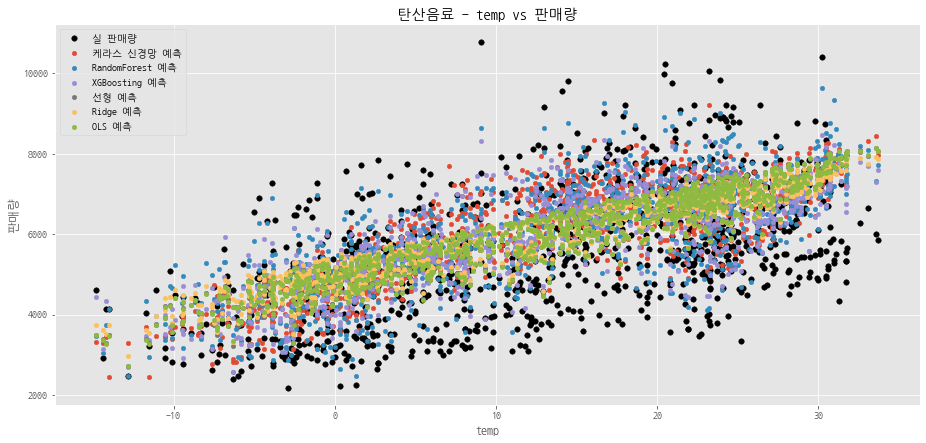

In [35]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_비o', 'snow_or_not_눈o']
n=1
# alpha 값 0~1
alp = 1
# scatter plot 점 크기
dot_size = 20

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=30, c='k', alpha = 1)
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

## 실험 구간

In [ ]:

# # 2016~2017 : 훈련 / 2018 검증 2:1
# trainXy = gs_week_w.loc[:cut_line]
# testXy = gs_week_w.loc[cut_line:]
# train_X =pd.DataFrame(trainXy.loc[:,'temp'])
# train_y = trainXy.loc[:,'qty']
# val_X = pd.DataFrame(testXy.loc[:,'temp'])
# val_y = testXy.loc[:,'qty']



# print('여기서 점수란 R-square값을 의미한다.')
# # RandomForest 회귀분석
# RFmodel = RandomForestRegressor()
# RFmodel.fit(train_X,train_y)
# # Get the mean absolute error on the validation data
# RFpredicted = RFmodel.predict(val_X)
# MAE = mean_absolute_error(val_y , RFpredicted)
# print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# # print('Random forest validation MAE = ', MAE)
# print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# # XGBRegressor 회귀분석
# XGBModel = XGBRegressor(objective='reg:squarederror')
# XGBModel.fit(train_X,train_y , verbose=False)
# # Get the mean absolute error on the validation data :
# XGBpredictions = XGBModel.predict(val_X)
# MAE = mean_absolute_error(val_y , XGBpredictions)
# print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# # print('XGBoost validation MAE = ',MAE)
# print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

# linReg = LinearRegression().fit(train_X, train_y)
# print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

# ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
# print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

# lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
# print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
# print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

# customF = formulaGen(target='qty',ind_features=['temp'])
# olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
# print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )

# combined = pd.DataFrame(gs_week_w.loc[:,'temp'])
# target = gs_week_w.loc[:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# # predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# result_df = pd.DataFrame()
# result_df['week'] = gs_week_w['week']
# result_df['qty'] = gs_week_w.loc[:,'qty']

# # print("keras 신경망 predictions",predictions.shape)
# # result_df['keras_qty'] = predictions

# # print("randomforest 예상",RFpredicted.shape)
# result_df['rf_qty'] = RFpredicted

# # print("XGBpredictions",XGBpredictions.shape)
# result_df['xgb_qty'] = XGBpredictions

# # print("linearRegression 예상",RFpredicted.shape)
# result_df['lin_qty'] = linPred

# # print("Ridge 예상",RFpredicted.shape)
# result_df['ridge_qty'] = ridPred

# # print("Lasso 예상",RFpredicted.shape)
# result_df['lasso_qty'] = lassoPred

# # print("OLS 예상",RFpredicted.shape)
# result_df['ols_qty'] = olsPred

# ============================================

In [ ]:
# df_graph = result_df.loc[:,['week','qty','keras_qty','rf_qty','xgb_qty','lin_qty','ridge_qty','lasso_qty','ols_qty']]
# for_visual_col = ['week','temp','cloud','wind','lgt_time','snow','rain','PM10']
# df = pd.merge(df_graph, gs_week_w[for_visual_col], on='week', how='left')
# # df.head(1)

In [ ]:
# 2016, 온도
# df_graph = df.loc[df.week <= 53]
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph.temp,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.scatter(df_graph.temp,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.scatter(df_graph.temp,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.scatter(df_graph.temp,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.scatter(df_graph.temp,df_graph.lin_qty, ls='-', label='linear예측')
# plt.scatter(df_graph.temp,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.scatter(df_graph.temp,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.scatter(df_graph.temp,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [ ]:
# qty_columns = list(df_graph.columns)[1:9]
# weather_columns = list(df_graph.columns)[9:]
# print(qty_columns)
# print(weather_columns)

In [ ]:
# x_temp = pd.DataFrame()
# # x_temp['temp'] = list(range(-10,35,1))
# x_temp['temp'] = np.arange(-9,35,0.5)
# combined = x_temp
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# # 2016~2018, 일조시간
# df_graph = df.copy()
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.7)
# plt.plot(x_temp, RFpredicted, label = 'rf')
# plt.plot(x_temp, XGBpredictions, label = 'xgb')
# plt.plot(x_temp, linPred, label = 'line')
# plt.plot(x_temp, ridPred, label = 'ridge')
# plt.plot(x_temp, lassoPred, label = 'lasso')
# plt.plot(x_temp, olsPred, label = 'ols')
# plt.plot()
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.xlabel(weather_columns[0])
# plt.ylabel('판매량 (단위 : 1개)')
# plt.show()

# 실험

In [ ]:
# intercept_lin = linReg.intercept_
# coef_line = linReg.coef_
# # list_col
# linePredict = list()
# x_temp = list(range(-10,38,1))
# for temperature in x_temp:
#     linePredict.append(intercept_lin + coef_line[0]*temperature)

    
# # 2016~2018, 일조시간
# df_graph = df.copy()
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.3)
# # for q_name in qty_columns:
# #     plt.plot(df_graph[weather_columns[0]],df_graph[q_name], ls='-', label=q_name)
# #     plt.scatter(df_graph.lgt_time,df_graph[q_name], ls='-', label='실제', color='green', alpha=0.5, lw=8)
# #     plt.scatter(df_graph.lgt_time,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# #     plt.scatter(df_graph.lgt_time,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# #     plt.scatter(df_graph.lgt_time,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# #     plt.scatter(df_graph.lgt_time,df_graph.lin_qty, ls='-', label='linear예측')
# #     plt.scatter(df_graph.lgt_time,df_graph.ridge_qty, ls='-', label='ridge예측')
# #     plt.scatter(df_graph.lgt_time,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# #     plt.scatter(df_graph.lgt_time,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.plot(x_temp, linePredict, 'r--', label='linear회귀, 온도만')

# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.xlabel(weather_columns[0])
# plt.ylabel('판매량 (단위 : 1개)')
# plt.show()

# 시간의 경과에 따른 예측량 비교

In [ ]:
# # 2016
# df_graph = result_df.loc[result_df.week <=53]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [ ]:
# # 2017
# df_graph = result_df.loc[(result_df.week >=53)&(result_df.week <=105)]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
# plt.legend()
# plt.show()

In [ ]:
# # 2018
# df_graph = result_df.loc[(result_df.week >=105)]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
# plt.legend()
# plt.show()

In [ ]:
# # 2016~2018
# plt.figure(figsize=(15.5, 10))
# plt.plot(result_df.week,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(result_df.week,result_df.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(result_df.week,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(result_df.week,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.legend()
# plt.show()

In [ ]:
# def r2_score(v_true, v_pred):
#     ssr = np.sum(np.square(v_pred - np.mean(v_true)))
#     sst = np.sum(np.square(v_true - np.mean(v_true)))
#     return ( ssr / sst)

In [ ]:
# checked_for = '2016~2017'
# combined = aaaaa.loc[:106,'temp':'PM10']
# target = aaaaa.loc[:106,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)
# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# checked_for = '2018'
# combined = aaaaa.loc[106:,'temp':'PM10']
# target = aaaaa.loc[106:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# checked_for = '2016~2018'
# combined = aaaaa.loc[:,'temp':'PM10']
# target = aaaaa.loc[:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# path = 'D:/project/contest/data/result/'
# result_df.to_csv(path+item+'_'+grouped_by+'_predict(lowVIF07).csv', encoding='utf-8', index=False)